# Importing and trainig a model

## Defining methods

In [1]:
import pandas as pd


import html
import unicodedata
import string
import re
from nltk.stem import WordNetLemmatizer
from html.parser import HTMLParser
from pattern.en import tag
import nltk
from nltk.corpus import wordnet as wn
from sklearn import metrics
import numpy as np
import pandas as pd
from random import shuffle
from matplotlib import pyplot as plt
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict


def build_feature_matrix(documents, max_features=None,
                         feature_type='frequency',
                         ngram_range=(1, 1),
                         min_df=0.0, max_df=1.0,
                         ):

    feature_type = feature_type.lower().strip()

    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, 
                                     min_df=min_df,
                                     max_df=max_df, 
                                     ngram_range=ngram_range,
                                     max_features = max_features)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False,
                                     min_df=min_df,
                                     max_df=max_df, 
                                     ngram_range=ngram_range, 
                                     max_features=max_features)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, 
                                     max_df=max_df,
                                     ngram_range=ngram_range,
                                     max_features=max_features)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)

    return vectorizer, feature_matrix


def remove_citation(text):
    return ' '.join(re.sub("(@[A-Za-z0-9_]+)"," ",text).split())


def remove_https(text):
    return re.sub(r'http\S+', '', text)

def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_diacritics(text):
    text = unicodedata.normalize('NFKD',str.encode(text).decode('utf-8')).encode('ascii', 'ignore')
    return text


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
        self.convert_charrefs=[]
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_html(text):
    html_stripper = MLStripper()
    html_stripper.feed(text)
    return html_stripper.get_data()

def normalize_tweet_corpus(corpus, only_text_chars=False):

    normalized_corpus = []
    for index, text in enumerate(corpus):
        text = remove_citation(text)
        text = remove_https(text)
        text = remove_diacritics(text)
        text = html.parser.unescape(text.decode())
        text = strip_html(text)
                
        if only_text_chars:
            text = keep_text_characters(text)
        
        text = text.lower()
        normalized_corpus.append(text)

    return normalized_corpus

def evaluate_classifier(clf, train_features, y_train):
    clf_score = cross_val_score(clf,train_features,y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print("Accuracy: %0.3f (+/- %0.3f)" % (clf_score.mean(), clf_score.std() * 2))
    y_train_pred = cross_val_predict(clf, train_features, y_train, cv=5)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(conf_mx,['negative','positive','neutro'],normalize=True)
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    

In [2]:
tweet = 'Hoje  estou de boa com a vida, até amanhã :) #boladão. @claudinhodavila http://vidaloca'
norm_tweet = normalize_tweet_corpus([tweet], only_text_chars=True)
print(norm_tweet[0])

hoje estou de boa com a vida ate amanha boladao


In [3]:
df_pos_neg = pd.read_csv('samples/pos_neg.csv')
df_neutro = pd.read_csv('samples/neutro.csv')
df_pos_neg_u = df_pos_neg.drop_duplicates('tweet_text')

# shuffle dataset
df_pos_neg_u = df_pos_neg_u.sample(frac=1).reset_index(drop=True)
df_neutro = df_neutro.sample(frac=1).reset_index(drop=True)

In [4]:
df_pos_neg_e = pd.concat([df_pos_neg_u[df_pos_neg_u['sentiment']==0][:len(df_neutro)],
                          df_pos_neg_u[df_pos_neg_u['sentiment']==1][:len(df_neutro)]])

df_pos_neg_e = df_pos_neg_e.sample(frac=1).reset_index(drop=True)

df_pos_neg_neutro = pd.concat([df_pos_neg_e,df_neutro])

df_pos_neg_neutro = df_pos_neg_neutro.sample(frac=1).reset_index(drop=True)


In [5]:
df_pos_neg_neutro['sentiment'].value_counts()

0.0    52990
2.0    52990
1.0    52990
Name: sentiment, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_pos_neg_neutro['tweet_text'].values, df_pos_neg_neutro['sentiment'].values,
                                                    stratify=df_pos_neg_neutro['sentiment'].values, 
                                                    test_size=0.3)

In [7]:
X_test

array(['Os analistas que ajudam investidores a lucrar com o vaivém da Bolsa https://t.co/bxJDrlcWOe',
       'Pra mim não aparece o emoji da Tag do BTS aaaa 💔 :( #BTSLoveYourselfTour #YTUnfreezeIDOL',
       'acordei agora :) hora de posta muitos memes por minuto pra compensar',
       ...,
       'Estou baixando a Trasgo 11, repleta de contos de FC e Fantasia de primeira! :D https://t.co/VQ2yDNpcds via @revistatrasgo',
       'minha mãe pediu pra eu dormir com ela hoje que elq tá muito assustada ainda :(',
       'É, aparentemente vou ter q colar sozinho no rolê amanhã :('],
      dtype=object)

In [8]:
# training tweets
norm_train_tweets = normalize_tweet_corpus(X_train, only_text_chars=False)

In [9]:
# extract features
# --------------------
# train_features
vectorizer, train_features = build_feature_matrix(documents=norm_train_tweets,
                                                  feature_type='frequency',
                                                  ngram_range=(1, 2),
                                                  min_df=0.0, 
                                                  max_df=1.0)

In [10]:
# normalize tweets
norm_test_tweets = normalize_tweet_corpus(X_test, only_text_chars=False)

# test_features
test_features = vectorizer.transform(norm_test_tweets)

In [11]:
train_features.shape

(111279, 589535)

In [12]:
test_features.shape

(47691, 589535)

### Models to try

In [18]:

from sklearn.naive_bayes import MultinomialNB

Accuracy: 0.802 (+/- 0.002)
[[0.76987572 0.21200766 0.01811663]
 [0.24125846 0.70277411 0.05596743]
 [0.01412665 0.05370285 0.93217049]]


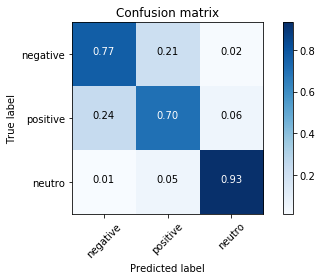

In [14]:
clf = MultinomialNB(alpha=2.2, fit_prior=True, class_prior=None)
evaluate_classifier(clf,train_features=train_features,y_train=y_train)

In [110]:
clf.fit(train_features, y_train)

MultinomialNB(alpha=2.2, class_prior=None, fit_prior=True)

[[0.76322577 0.21821727 0.01855696]
 [0.22979178 0.7141599  0.05604831]
 [0.01182613 0.05422407 0.9339498 ]]


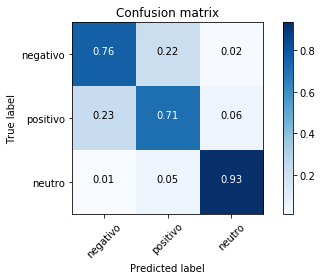

In [112]:
y_pred = clf.predict(test_features)
conf_mx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mx, ['negativo','positivo','neutro'],
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [113]:
tweet = 'Hoje eu estou com muita dor :/ #fimdesemana @arminio https://vidaloca'
norm_tweet = normalize_tweet_corpus([tweet], only_text_chars=False)
print(norm_tweet)
tweet_features = vectorizer.transform(norm_tweet)



['Hoje eu estou com muita dor :/ #fimdesemana ']


In [114]:
tweet_features.shape

(1, 589456)

In [118]:
int(clf.predict(tweet_features)[0])

0

In [116]:
# Save a dictionary into a pickle file.
import pickle

pickle.dump( clf, open( "model_sdg_svm.pickle", "wb" ) )
pickle.dump( vectorizer, open('vectorizer.pickle','wb'))

In [120]:
    # Getting back the vectorizer:
    vectorizer = pickle.load( open( "vectorizer.pickle", "rb" ) )
    tweet_features = vectorizer.transform(norm_tweet)

    # Getting model
    clf = pickle.load(open("model.pickle", "rb"))
    sentiment=int(clf.predict(tweet_features)[0])
    sentiment

0

## Try with one vs one

Accuracy: 0.798 (+/- 0.006)
[[0.79392338 0.18946971 0.01660691]
 [0.27714124 0.66966813 0.05319063]
 [0.01725393 0.05370285 0.92904322]]


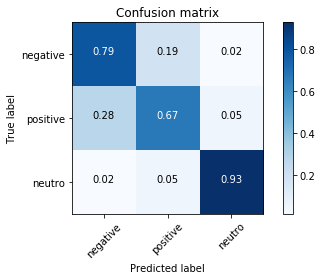

In [138]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(MultinomialNB())
evaluate_classifier(ovo_clf,train_features, y_train)

Accuracy: 0.545 (+/- 0.014)
[[0.65389696 0.21103712 0.13506592]
 [0.35621276 0.44450435 0.19928288]
 [0.19693743 0.26554876 0.53751382]]


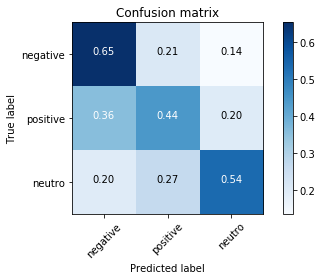

In [148]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
evaluate_classifier(clf,train_features=train_features,y_train=y_train)

Accuracy: 0.789 (+/- 0.032)
[[0.64869382 0.34809802 0.00320815]
 [0.36462405 0.61359286 0.02178309]
 [0.2017901  0.23788855 0.56032135]]


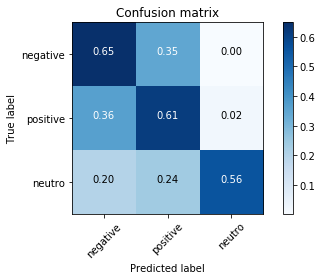

In [150]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(5, 2)
                   )
evaluate_classifier(clf,train_features=train_features,y_train=y_train)

Accuracy: 0.675 (+/- 0.342)
[[0.70258539 0.27711428 0.02030033]
 [0.25940204 0.68611328 0.05448467]
 [0.0177392  0.060227   0.92203381]]


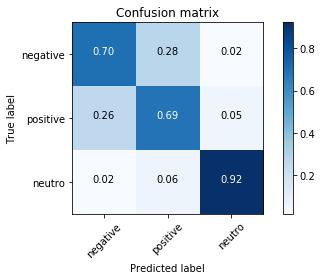

In [151]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', 
                    alpha=1e-5,
                    hidden_layer_sizes=(4, 3)
                   )
evaluate_classifier(clf,train_features=train_features,y_train=y_train)

### Fine tunning

In [153]:
clf = MultinomialNB()

In [14]:
from sklearn.model_selection import GridSearchCV

prior = [None,
 [0.1, 0.1, 0.1],
 [0.2, 0.2, 0.2],
 [0.30000000000000004, 0.30000000000000004, 0.30000000000000004],
 [0.4, 0.4, 0.4],
 [0.5, 0.5, 0.5],
 [0.6000000000000001, 0.6000000000000001, 0.6000000000000001],
 [0.7000000000000001, 0.7000000000000001, 0.7000000000000001],
 [0.8, 0.8, 0.8],
 [0.9, 0.9, 0.9],
 [1.0, 1.0, 1.0]]

param_grid = [
    {'alpha':[0.1*i for i in range(1, 100)], 'fit_prior':[True,False], 'class_prior':prior}
]

clf = MultinomialNB()

grid_search  = GridSearchCV(clf,param_grid, cv=5,scoring='accuracy')


In [15]:
grid_search.fit(train_features, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000...00001, 0.7000000000000001, 0.7000000000000001], [0.8, 0.8, 0.8], [0.9, 0.9, 0.9], [1.0, 1.0, 1.0]]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
grid_search.best_estimator_

MultinomialNB(alpha=2.2, class_prior=None, fit_prior=True)

Accuracy: 0.803 (+/- 0.004)
[[0.77569892 0.20809856 0.01620252]
 [0.24155501 0.70118351 0.05726148]
 [0.01377618 0.05300191 0.9332219 ]]


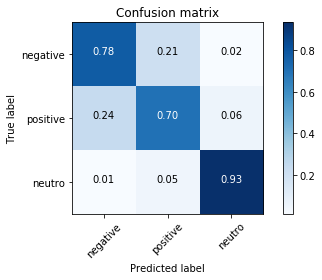

In [18]:
clf = MultinomialNB(alpha=2.2, fit_prior=True, class_prior=None)
evaluate_classifier(clf,train_features, y_train)

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [22]:

param_grid = [
    {'loss':['hinge',
             'log',
             'modified_huber'
            ], 
     'penalty': ['none','l2','l1'], 
     'alpha': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1],
     'l1_ratio': [i*0.1 for i in range(1,11)],
     'fit_intercept' :[True,False],
     'shuffle':[True,False], 
     'learning_rate':['optimal'],
    }   
]

clf = SGDClassifier()

grid_search  = GridSearchCV(clf,param_grid, cv=5,scoring='accuracy', n_jobs=-1)


In [23]:
grid_search.fit(train_features, y_train)

/Users/Valdir.Salustino@ibm.com/.virtualenvs/DESAFIOTWITTER/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'loss': ['hinge', 'log', 'modified_huber'], 'penalty': ['none', 'l2', 'l1'], 'alpha': [0.0001, 0.0005, 0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], 'fit_intercept': [True, False], 'shuffle': [True, False], 'learning_rate': ['optimal']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [24]:
grid_search.best_params_

{'alpha': 0.0005,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'penalty': 'l2',
 'shuffle': True}

In [25]:
grid_search.best_estimator_

SGDClassifier(alpha=0.0005, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.5, learning_rate='optimal', loss='modified_huber',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)

Accuracy: 0.823 (+/- 0.003)


/Users/Valdir.Salustino@ibm.com/.virtualenvs/DESAFIOTWITTER/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[[0.75647696 0.2345456  0.00897744]
 [0.2185318  0.75041113 0.03105707]
 [0.00647022 0.02873858 0.9647912 ]]


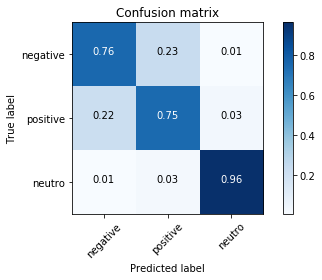

In [26]:
clf = grid_search.best_estimator_
evaluate_classifier(clf, train_features, y_train)

In [27]:
clf.fit(train_features, y_train)

SGDClassifier(alpha=0.0005, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.5, learning_rate='optimal', loss='modified_huber',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)

[[0.7839844  0.20739762 0.00861798]
 [0.23998239 0.72843933 0.03157829]
 [0.00780021 0.02528779 0.966912  ]]


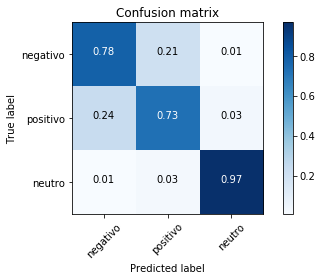

In [28]:
y_pred = clf.predict(test_features)
conf_mx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mx, ['negativo','positivo','neutro'],
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [29]:
# Save a dictionary into a pickle file.
import pickle

pickle.dump( clf, open( "model_sdg_svm.pickle", "wb" ) )
pickle.dump( vectorizer, open('vectorizer.pickle','wb'))